In [ ]:
import scanpy as sc 
import numpy as np 
import pandas as pd 

In [ ]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3549
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'leiden', 'leiden_R', 'cell_type_2'
    uns: 'author_cell_type_colors', 'cell_thresholds', 'cell_type_2_colors', 'cell_type_colors', 'dendrogram_leiden', 'leiden', 'leiden_R', 'leiden_colors', 'ligand_receivers', 'neighbors', 'pca', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count'
    obsp: 'connectivities', 'distances'

In [ ]:
import scenvi 

st_data = adata
st_data.obsm['COVET'], st_data.obsm['COVET_SQRT'], st_data.uns['CovGenes'] = scenvi.compute_covet(st_data)

In [5]:
def flatten(arr):
    return(np.reshape(arr, [arr.shape[0], -1]))

def force_directed_layout(affinity_matrix, cell_names=None, verbose=True, iterations=500, device='cpu'):
    """" Function to compute force directed layout from the affinity_matrix
    :param affinity_matrix: Sparse matrix representing affinities between cells
    :param cell_names: pandas Series object with cell names
    :param verbose: Verbosity for force directed layout computation
    :param iterations: Number of iterations used by ForceAtlas
    :return: Pandas data frame representing the force directed layout
    """

    init_coords = np.random.random((affinity_matrix.shape[0], 2))

    if device == 'cpu':
        forceatlas2 = ForceAtlas2(
            # Behavior alternatives
            outboundAttractionDistribution=False,
            linLogMode=False,
            adjustSizes=False,
            edgeWeightInfluence=1.0,
            # Performance
            jitterTolerance=1.0,
            barnesHutOptimize=True,
            barnesHutTheta=1.2,
            multiThreaded=False,
            # Tuning
            scalingRatio=2.0,
            strongGravityMode=False,
            gravity=1.0,
            # Log
            verbose=verbose)

        positions = forceatlas2.forceatlas2(
            affinity_matrix, pos=init_coords, iterations=iterations)
        positions = np.array(positions)


    positions = pd.DataFrame(positions,
                             index=np.arange(affinity_matrix.shape[0]), columns=['x', 'y'])
    return positions

def run_diffusion_maps(data_df, n_components=10, knn=30, alpha=0):
    """Run Diffusion maps using the adaptive anisotropic kernel
    :param data_df: PCA projections of the data or adjacency matrix
    :param n_components: Number of diffusion components
    :param knn: Number of nearest neighbors for graph construction
    :param alpha: Normalization parameter for the diffusion operator
    :return: Diffusion components, corresponding eigen values and the diffusion operator
    """

    # Determine the kernel
    N = data_df.shape[0]

    if(type(data_df).__module__ == np.__name__):
        data_df = pd.DataFrame(data_df)

    if not scipy.sparse.issparse(data_df):
        print("Determing nearest neighbor graph...")
        temp = sc.AnnData(data_df.values)
        sc.pp.neighbors(temp, n_pcs=0, n_neighbors=knn)
        kNN = temp.obsp['distances']

        # Adaptive k
        adaptive_k = int(np.floor(knn / 3))
        adaptive_std = np.zeros(N)

        for i in np.arange(len(adaptive_std)):
            adaptive_std[i] = np.sort(kNN.data[kNN.indptr[i] : kNN.indptr[i + 1]])[
                adaptive_k - 1
            ]

        # Kernel
        x, y, dists = scipy.sparse.find(kNN)

        # X, y specific stds
        dists = dists / adaptive_std[x]
        W = scipy.sparse.csr_matrix((np.exp(-dists), (x, y)), shape=[N, N])

        # Diffusion components
        kernel = W + W.T
    else:
        kernel = data_df

    # Markov
    D = np.ravel(kernel.sum(axis=1))

    if alpha > 0:
        # L_alpha
        D[D != 0] = D[D != 0] ** (-alpha)
        mat = scipy.sparse.csr_matrix((D, (range(N), range(N))), shape=[N, N])
        kernel = mat.dot(kernel).dot(mat)
        D = np.ravel(kernel.sum(axis=1))

    D[D != 0] = 1 / D[D != 0]
    T = scipy.sparse.csr_matrix((D, (range(N), range(N))), shape=[N, N]).dot(kernel)
    # Eigen value dcomposition
    D, V = scipy.sparse.linalg.eigs(T, n_components, tol=1e-4, maxiter=1000)
    D = np.real(D)
    V = np.real(V)
    inds = np.argsort(D)[::-1]
    D = D[inds]
    V = V[:, inds]

    # Normalize
    for i in range(V.shape[1]):
        V[:, i] = V[:, i] / np.linalg.norm(V[:, i])

    # Create are results dictionary
    res = {"T": T, "EigenVectors": V, "EigenValues": D}
    res["EigenVectors"] = pd.DataFrame(res["EigenVectors"])
    if not scipy.sparse.issparse(data_df):
        res["EigenVectors"].index = data_df.index
    res["EigenValues"] = pd.Series(res["EigenValues"])
    res["kernel"] = kernel

    return res


def FDL(data, k = 30):


    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=int(k), metric='euclidean',
                               n_jobs=5).fit(data)
    kNN = nbrs.kneighbors_graph(data, mode='distance')
    # Adaptive k

    adaptive_k = int(np.floor(k / 3))
    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=int(adaptive_k),
                           metric='euclidean', n_jobs=5).fit(data)
    adaptive_std = nbrs.kneighbors_graph(data, mode='distance').max(axis=1)
    adaptive_std = np.ravel(adaptive_std.todense())
    # Kernel
    x, y, dists = scipy.sparse.find(kNN)
    # X, y specific stds
    dists = dists / adaptive_std[x]
    N = data.shape[0]
    W = scipy.sparse.csr_matrix((np.exp(-dists), (x, y)), shape=[N, N])
    # Diffusion components
    kernel = W + W.T
    layout = force_directed_layout(kernel)
    return(layout)

In [6]:
st_data_sst = st_data

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc
import colorcet
import sklearn.neighbors
import scipy.sparse
import umap.umap_ as umap
from fa2 import ForceAtlas2

In [7]:
FDL_COVET = np.asarray(FDL(flatten(st_data_sst.obsm['COVET_SQRT']), k = 30))

st_data_sst.obsm['FDL_COVET'] = FDL_COVET

100%|██████████| 500/500 [00:33<00:00, 15.08it/s]

BarnesHut Approximation  took  16.90  seconds
Repulsion forces  took  14.02  seconds
Gravitational forces  took  0.11  seconds
Attraction forces  took  0.83  seconds
AdjustSpeedAndApplyForces step  took  0.56  seconds


In [8]:
DC_COVET = np.asarray(run_diffusion_maps(flatten(st_data_sst.obsm['COVET_SQRT']), knn = 30)['EigenVectors'])[:, 1:]
st_data_sst.obsm['DC_COVET'] = -DC_COVET

Determing nearest neighbor graph...


In [9]:
st_data.write_h5ad('covet.h5ad')
FDL_COVET.shape, DC_COVET.shape

((5778, 2), (5778, 9))

In [23]:
data.shape

(5778, 64, 64)

In [1]:
import sys
import anndata as ad 

sys.path.append('/ix/djishnu/alw399/methods/PhenoGraph/')

st_data_sst = ad.read('covet.h5ad')
st_data_sst

AnnData object with n_obs × n_vars = 5778 × 3549
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'leiden', 'leiden_R', 'cell_type_2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CovGenes', 'author_cell_type_colors', 'cell_thresholds', 'cell_type_2_colors', 'cell_type_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_R', 'leiden_colors', 'ligand_receivers', 'neighbors', 'pca', 'received_ligands_tfl', 'umap'
    obsm: 'COVET', 'COVET_SQRT', 'DC_COVET', 'FDL_COVET', 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'log', 'normalized_count'
    obsp: 'connectivities', 'distances'

In [2]:
import phenograph

# data = []
# for cell in st_data_sst.obsm['COVET_SQRT']:
#     data.append(cell.flatten().tolist())

data = st_data_sst.obsm['COVET_SQRT'].reshape(st_data_sst.shape[0], -1)
communities, graph, Q = phenograph.cluster(data, jaccard=False)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 3.3180761337280273 seconds
Gaussian kernel graph constructed in 0.24597835540771484 seconds
Wrote graph to binary file in 0.10135626792907715 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.655366
After 7 runs, maximum modularity is Q = 0.657686
Louvain completed 27 runs in 3.4578893184661865 seconds
PhenoGraph complete in 7.2143402099609375 seconds


In [6]:
st_data_sst.obs['phenograph_clusters'] = communities

In [9]:
st_data_sst.write_h5ad('covet_phenograph.h5ad')

In [1]:
import scanpy as sc 
adata = sc.read_h5ad('covet.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3549
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'leiden', 'leiden_R', 'cell_type_2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CovGenes', 'author_cell_type_colors', 'cell_thresholds', 'cell_type_2_colors', 'cell_type_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_R', 'leiden_colors', 'ligand_receivers', 'neighbors', 'pca', 'received_ligands_tfl', 'umap'
    obsm: 'COVET', 'COVET_SQRT', 'DC_COVET', 'FDL_COVET', 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'log', 'normalized_count'
    obsp: 'connectivities', 'distances'

In [5]:
adata.obsm['COVET_SQRT'].shape

(5778, 64, 64)

In [6]:
adata.write_h5ad('/ix/djishnu/shared/djishnu_kor11/covet_outputs/tonsil_covet.h5ad')

In [ ]:
import matplotlib.pyplot as plt 
import scanpy as sc 

st_data_sst = sc.read_h5ad('covet_phenograph.h5ad')

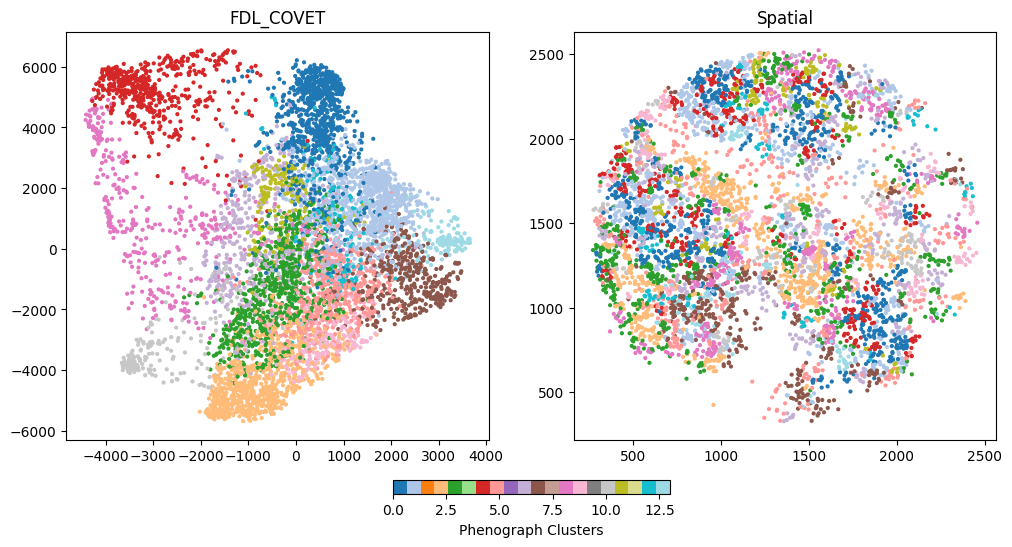

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Set up the color map based on 'phenograph_clusters' for categorical data
scatter1 = axes[0].scatter(
    st_data_sst.obsm['FDL_COVET'][:, 0],
    st_data_sst.obsm['FDL_COVET'][:, 1], 
    c=st_data_sst.obs['phenograph_clusters'].astype('category').cat.codes,  # Convert to categorical codes
    s=4,
    cmap='tab20'  # Discrete colormap for categorical data
)
axes[0].set_title('FDL_COVET')

# Second scatter plot (spatial)
scatter2 = axes[1].scatter(
    st_data_sst.obsm['spatial'][:, 0],
    st_data_sst.obsm['spatial'][:, 1],
    c=st_data_sst.obs['phenograph_clusters'].astype('category').cat.codes,  # Use the same categorical codes
    s=4,
    cmap='tab20'  # Same colormap to ensure joint legend
)
axes[1].set_title('Spatial')

# Add a common colorbar below the plots
cbar = fig.colorbar(scatter1, ax=axes, orientation='horizontal', fraction=0.03, pad=0.1)
cbar.set_label('Phenograph Clusters')

# Adjust the layout to ensure the colorbar does not overlap the plots
plt.subplots_adjust(bottom=0.2)  # Increase bottom margin for colorbar

# Show the plot
plt.show()
